<a href="https://colab.research.google.com/github/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Chapter_1_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1 - Regression

For a regression problem, we want to build a model that can learn how different features (properties) of a system contribute **quantitatively** to that system.

The typical architecture of such an ANN is:

| Layer      | Description |
| ---------- | ----------- |
| Input      |Takes numeric coded features as input|
| Hidden     |Optional deep layers|
| Output     |Linear output to predict numeric values|


![](https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Regression%20network%20topology.jpg?raw=true)

In [82]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

# Bradford Standard Curve

In the first section, we will build a model that learns the relationship between protein concentration (x-axis) and the corresponding absorbance (y-axis) at 595 nm to demonstrate the following basic principles:
- How a human and a machine would model a linear relationship
- How to build a simple artificial neural "network" consisting of 1 neuron
- What a loss function is
- How a neural network learns
- Why ANNs need a huge amount of data

**Let's genereate a toy data set cosisting of 20 data points**

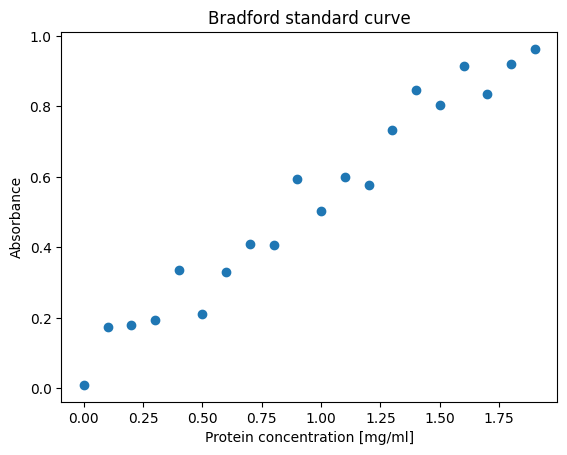

In [83]:
# Generate realistic data set with 20 data points according to the equation y = 0.52*x + 0.05
x = np.arange(0,2,0.1)
y = (0.52 * x + 0.05) + np.random.uniform(-1, 1, size=20) / 10

# Visualize the whole dataset
plt.scatter(x,y)
plt.xlabel("Protein concentration [mg/ml]")
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");

## How would a human model a line representing the data set?

Key steps:
1. **Observation**
  - What does the graph look like versus what do the values look like? The graphical representation is probably easier for us to understand.
2. **Pattern Recognition**
  - As the protein concentration increases, so does the absorbance.
3. **Generalization**
  - The system is linear / a line can be used to model the system
4. **Adjustment**
  - Trial and error

Resulting possible actions:
1. Low complexity
  - Take any line-shaped object and adjust it to the best possible overlap with the data. Now you can use the object to predict the protein concentration from the absorbance.
2. Moderate complexity
  - You draw a line between the starting data point and the ending data point and use this line to make predictions.
3. High complexity
  - You calculate the average **slope m** and the average **intercept n** and construct a line using the equation f(x) = m*x + n.

**Now we will do a trial-and-error solution somewhere between moderate and high complexity. We will change the slope m and the intercept n of a line, which will then be drawn and compared to the data**

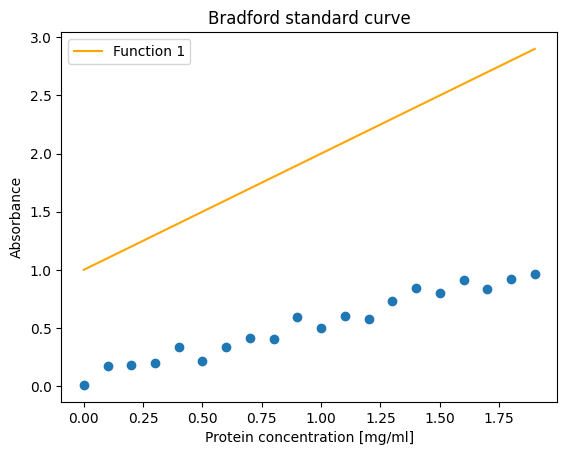

In [84]:
# Let's create a model manually by modelling a line: y = m*x + n

# Parameters for the line
m = 1
n = 1

# Calculate y values resulting from our model y = m*x + n
function_1 = m*x + n

# Plot model as line into train dataset
plt.scatter(x, y)
plt.plot(x, function_1, label="Function 1", color="orange")
plt.xlabel("Protein concentration [mg/ml]")
plt.legend()
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");

Computers cannot see like us and move the line around the plot. They need a machine-readable metric that they will try to minimize (**loss function, cost function**).
In the case of regression, two very popular metrics are **mean absolute error (MAE)** and **mean squared error (MSE)**.
> MAE = $ \frac {1} {n} \displaystyle\sum_{i = 1}^{n} |y_{true}^{i} - y_{pred}^{i}|$

> MSE = $ \frac {1} {n} \displaystyle\sum_{i = 1}^{n} (y_{true}^{i} - y_{pred}^{i})^2$


**This time we will try to fit the curve without the graph. We will use MAE and MSE as metrics of how well our model represents the system.**

In [85]:
# Parameters for the line
m = 1
n = 1

# Calculate y values resulting from our model y = m*x + n
function_2 = m*x + n

# Evaluate the manual model by mean absolute error and mean squared error
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = m*x + n
eval_base_mae = mean_absolute_error(y_true=y, y_pred=y_pred)
eval_base_mse = mean_squared_error(y_true=y, y_pred=y_pred)

print(f"MSE : {eval_base_mse:.3f}, MAE: {eval_base_mae:.3f}")

MSE : 2.114, MAE: 1.423


**Now we will plot the second line into the plot with the first line and the data**

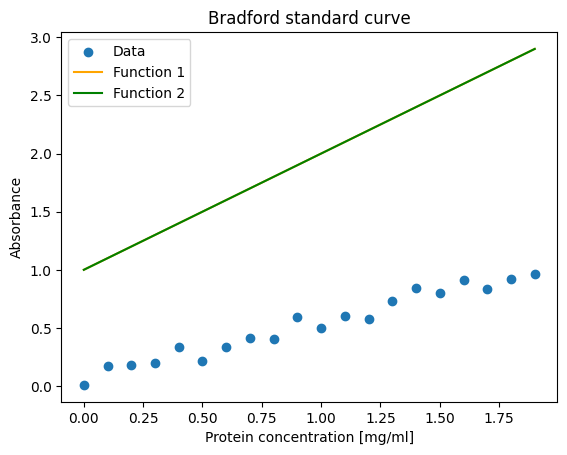

In [86]:
# Plot model as line and compare it to the previous model
plt.scatter(x, y, label="Data")
plt.plot(x, function_1, label="Function 1", color="orange")
plt.plot(x, function_2, label="Function 2", color="green")
plt.legend()
plt.xlabel("Protein concentration [mg/ml]")
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");

---
❓**Question**: Which method did you find easier? The visualization or the loss function?

---

## First neural network

---
Let's build our first neural network with the following components:
* **1 single dense neuron** (input and output are together)
* Linear activation function **f(x) = x**.
* Optimizer is **Stochastic Gradient Descent SGD**.
* Loss function to minimize: **Mean Absolute Error MAE**
* Metrics to observe during training: **Mean Absolute Error MAE**
* Train model for **10 epochs** and monitor each epoch

![](https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Regression%20model%201.jpg?raw=true)

**But first we convert our data into tensors and check the shape**

In [87]:
# Convert the list objects to tensors for downstream calculations
x_train = tf.convert_to_tensor(x)
y_train = tf.convert_to_tensor(y)

# Reshape tensors in (batch size-values) format
x_train = tf.expand_dims(x_train, axis=1)
y_train = tf.expand_dims(y_train, axis=1)

# Check the dimensions of the tensors
print(f" Datapoints in x_train: {len(x_train)} \n Shape of x_train: {x_train.shape} \n")
print(f" Datapoints in y_train: {len(y_train)} \n Shape of y_train: {y_train.shape} \n")
print(f" x_train: \n {x_train}")

 Datapoints in x_train: 20 
 Shape of x_train: (20, 1) 

 Datapoints in y_train: 20 
 Shape of y_train: (20, 1) 

 x_train: 
 [[0. ]
 [0.1]
 [0.2]
 [0.3]
 [0.4]
 [0.5]
 [0.6]
 [0.7]
 [0.8]
 [0.9]
 [1. ]
 [1.1]
 [1.2]
 [1.3]
 [1.4]
 [1.5]
 [1.6]
 [1.7]
 [1.8]
 [1.9]]


**Now we will build our first model**

In [88]:
# Neural network for regression problem

# Build model
model = keras.Sequential([layers.Dense(units=1,
                                       input_shape=x_train.shape[1:],
                                       kernel_initializer=tf.initializers.Constant(-0.8))])

# Compile model
model.compile(optimizer="SGD",
              loss="MAE",
              metrics=["MAE"])

# Show summary of our model
model.summary()

# Record first prediction of x_train before training
pred_0 = model.predict(x_train)
model_pred_df = pd.DataFrame(pred_0)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 50ms/step


---
❓ **Question:** How many trainable parameters does our model have? Can we use it to model a linear graph?

---

Now we plot the predictions of the initial model **before** training and check the weight and the bias neuron.

Typically, the weights are randomly initialized each time the model is built, and the bias neurons are initialized with 0. In this case, the initial weight is fixed to ensure reproducibility.

Initialized weight: -0.800000011920929 and initialized bias: 0.0


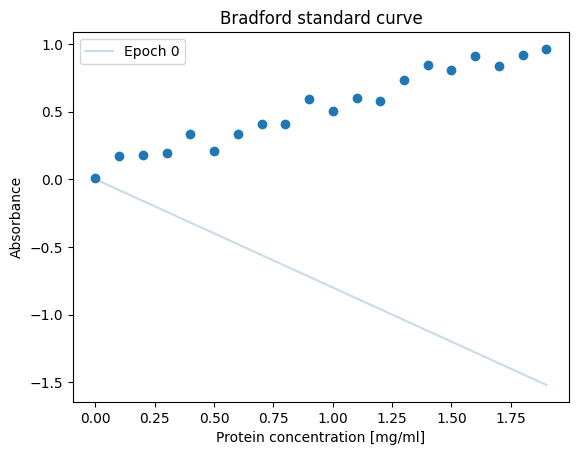

In [89]:
# Plot model progress as lines into whole dataset to see initial model prediction
plt.scatter(x_train, y_train)
for i in range(len(model_pred_df.columns)):
  plt.plot(x_train, model_pred_df[i], label="Epoch " + str(i*10), alpha=0.25)
plt.legend()
plt.xlabel("Protein concentration [mg/ml]")
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");
print(f"Initialized weight: {model.get_weights()[0].item()} and initialized bias: {model.get_weights()[1].item()}")

---
**Time to train the network**

> **Exercise:** Train the model until it represents the data as well as possible. Check the predictions every 10th epoch and note the total number of epochs needed to reach a good representation of the data.

Remember, each time you execute the following cell, the model is trained for 100 epochs!


Epoch 1/10
1/1 [==============================] - 0s 486ms/step - loss: 1.2872 - MAE: 1.2872
Epoch 2/10
1/1 [==============================] - 0s 19ms/step - loss: 1.2682 - MAE: 1.2682
Epoch 3/10
1/1 [==============================] - 0s 14ms/step - loss: 1.2511 - MAE: 1.2511
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 1.2340 - MAE: 1.2340
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 1.2168 - MAE: 1.2168
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 1.1997 - MAE: 1.1997
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 1.1826 - MAE: 1.1826
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 1.1655 - MAE: 1.1655
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 1.1483 - MAE: 1.1483
Epoch 10/10
1/1 [==============================] - 0s 41ms/step
Epoch 1/10
1/1 [==============================] - 0s 20ms/step - loss: 1.1141 - MAE: 1.1141
Epoch 2/10
1/1 

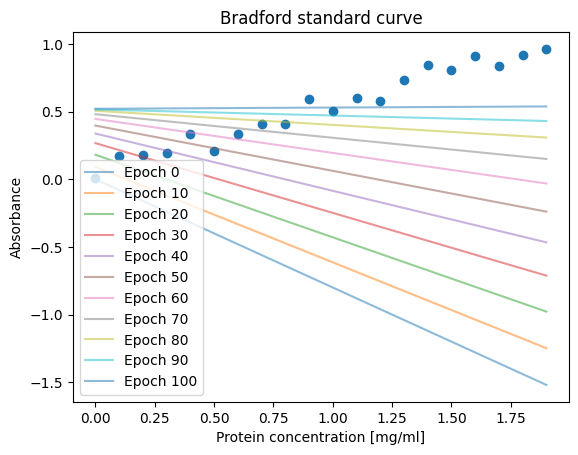

In [90]:
# Fit model and record every 10th epoch
for i in range(1,11):
  history_1 = model.fit(x_train, y_train, epochs=10)
  pred = model.predict(x_train)
  model_pred_df[i] = pd.DataFrame(pred)

# Plot model progress as lines into whole dataset
plt.scatter(x_train, y_train)
for i in range(len(model_pred_df.columns)):
  plt.plot(x_train, model_pred_df[i], label="Epoch " + str(i*10), alpha=0.5)
plt.legend()
plt.xlabel("Protein concentration [mg/ml]")
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");


Compare the MAE with the MAE you generated above. Probably, the ANN resulted in a lower MAE and thus the model found a better representation of the data set.

Compare the weights to the equation that was used to generate the dataset:
> f(x) = 0.52*x + 0.05


In [91]:
# Get the rounded weights of the perfect model
w1, w2 = model.get_weights()
w1 = round(w1.item(), 3)
w2 = round(w2.item(), 3)

# Get MAE of the final model by evaluating x_test
eval_nn = model.evaluate(x_train, y_train, verbose=0)[0]

print(f" Weight 1: {w1} \n Weight 2: {w2}")
print(f"\n MAE of ANN: {round(eval_nn,3)}")
print(f" MAE of manual approach: {round(eval_base_mae,3)}")

 Weight 1: 0.009 
 Weight 2: 0.521

 MAE of ANN: 0.247
 MAE of manual approach: 1.423


## The Curse of Small Data Sets

We could get a model capable of representing the data set with 20 data points, but it took hundreds of epochs.

Machine learning in general and artificial NN in particular perform best with large amounts of data.

Now we will repeat the experiment from above, but this time we will use 200 data points (in the same interval).

 Datapoints in x_train: 200 
 Shape of x_train: (200, 1) 

 Datapoints in y_train: 200 
 Shape of y_train: (200, 1) 



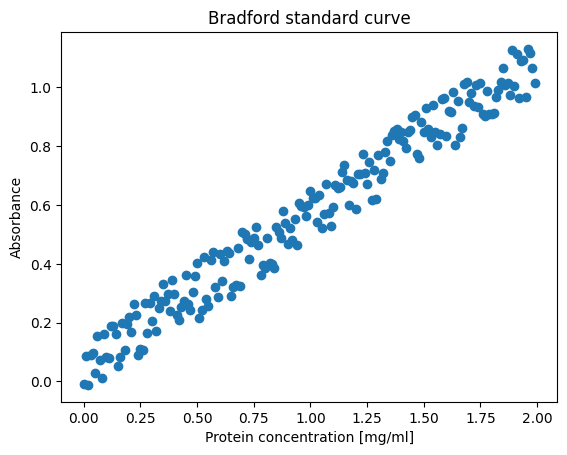

In [92]:
# Generate a realistic 200-point data set using the equation y = 0.52*x + 0.05
x = np.arange(0,2,0.01)
y = (0.52 * x + 0.05) + np.random.uniform(-1, 1, size=200) / 10

# Convert the list objects to tensors for downstream calculations
x_train = tf.convert_to_tensor(x)
y_train = tf.convert_to_tensor(y)

# Reshape tensors in (batch size-values) format
x_train = tf.expand_dims(x_train, axis=1)
y_train = tf.expand_dims(y_train, axis=1)

# Check the dimensions of the tensors
print(f" Datapoints in x_train: {len(x_train)} \n Shape of x_train: {x_train.shape} \n")
print(f" Datapoints in y_train: {len(y_train)} \n Shape of y_train: {y_train.shape} \n")

# Visualize whole dataset
plt.scatter(x,y)
plt.xlabel("Protein concentration [mg/ml]")
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");

**Now we use the exact same ANN as before but this time with 10 times more data points**

In [93]:
# Neural network for regression problem

# Build model
model = keras.Sequential([layers.Dense(units=1,
                                       input_shape=x_train.shape[1:],
                                       kernel_initializer=tf.initializers.Constant(-0.8))])

# Compile model
model.compile(optimizer="SGD",
              loss="MAE",
              metrics=["MAE"])

# Show summary of our model
model.summary()

# Record first prediction of x_train before training
pred_0 = model.predict(x_train)
model_pred_df = pd.DataFrame(pred_0)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
7/7 [==============================] - 0s 2ms/step


Initialized weight: -0.800000011920929 and initialized bias: 0.0


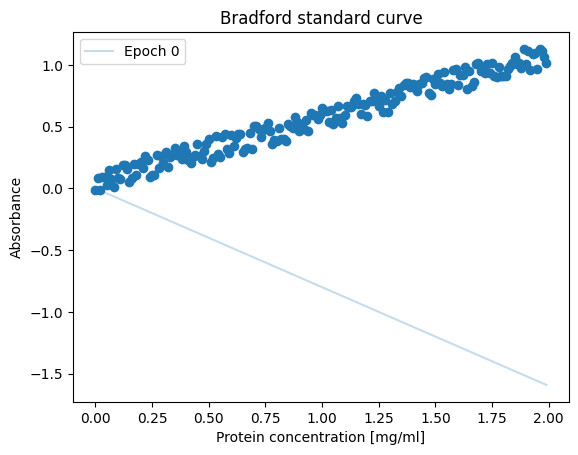

In [94]:
# Plot model progress as lines into whole dataset to see initial model prediction
plt.scatter(x_train, y_train)
for i in range(len(model_pred_df.columns)):
  plt.plot(x_train, model_pred_df[i], label="Epoch " + str(i*5), alpha=0.25)
plt.legend()
plt.xlabel("Protein concentration [mg/ml]")
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");
print(f"Initialized weight: {model.get_weights()[0].item()} and initialized bias: {model.get_weights()[1].item()}")

---
Time to train the network

> **Exercise:** Train the model until it represents the data as good as possible. Check the predictions every 10th epoch and record the number of total epochs needed to reach a good representation of the data


Epoch 1/5
7/7 [==============================] - 0s 3ms/step - loss: 1.3194 - MAE: 1.3194
Epoch 2/5
7/7 [==============================] - 0s 3ms/step - loss: 1.1825 - MAE: 1.1825
Epoch 3/5
7/7 [==============================] - 0s 3ms/step - loss: 1.0533 - MAE: 1.0533
Epoch 4/5
7/7 [==============================] - 0s 4ms/step - loss: 0.9285 - MAE: 0.9285
Epoch 5/5
7/7 [==============================] - 0s 2ms/step
Epoch 1/5
7/7 [==============================] - 0s 3ms/step - loss: 0.7138 - MAE: 0.7138
Epoch 2/5
7/7 [==============================] - 0s 3ms/step - loss: 0.6155 - MAE: 0.6155
Epoch 3/5
7/7 [==============================] - 0s 3ms/step - loss: 0.5315 - MAE: 0.5315
Epoch 4/5
7/7 [==============================] - 0s 3ms/step - loss: 0.4645 - MAE: 0.4645
Epoch 5/5
7/7 [==============================] - 0s 2ms/step
Epoch 1/5
7/7 [==============================] - 0s 3ms/step - loss: 0.3546 - MAE: 0.3546
Epoch 2/5
7/7 [==============================] - 0s 2ms/step - loss:

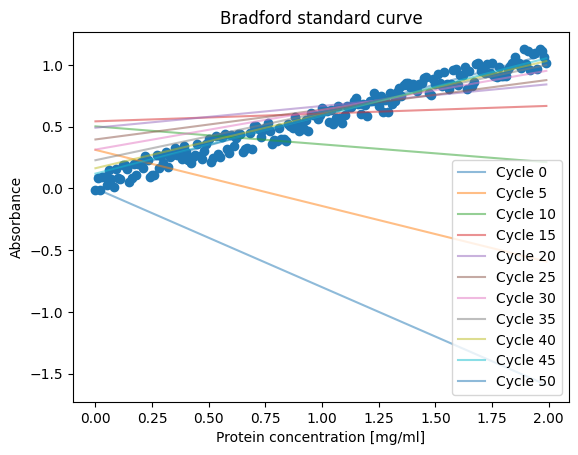

In [95]:
# Fit model and record every 10th epoch
for i in range(1,11):
  history_1 = model.fit(x_train, y_train, epochs=5)
  pred = model.predict(x_train)
  model_pred_df[i] = pd.DataFrame(pred)

# Plot model progress as lines into whole dataset
plt.scatter(x_train, y_train)
for i in range(len(model_pred_df.columns)):
  plt.plot(x_train, model_pred_df[i], label="Cycle " + str(i*5), alpha=0.5)
plt.legend()
plt.xlabel("Protein concentration [mg/ml]")
plt.ylabel("Absorbance")
plt.title("Bradford standard curve");

**This time it took only ~50 epochs to converge**

# Fitting Regression for Growth Curve

Now we are going to build a model that can predict the OD of our favorite microorganism during diauxic growth to demonstrate the following principles:
- What are activation functions and why are they important?
- How can an ANN model non-linear data?


**First we create the toy dataset with 2000 data points**

 Datapoints in x_train: 2000 
 Shape of x_train: (2000, 1) 

 Datapoints in y_train: 2000 
 Shape of y_train: (2000, 1) 



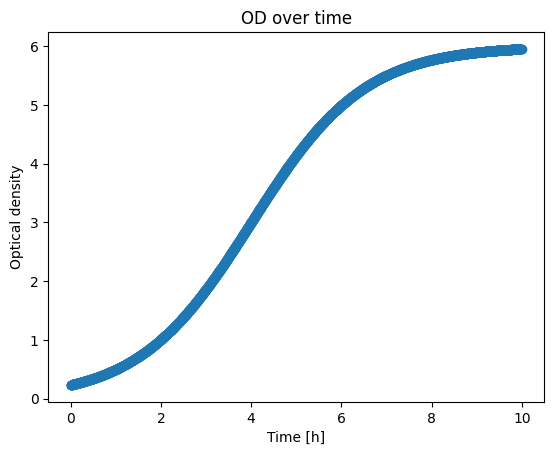

In [96]:
# Create dataset
def diauxic_growth(x, k, l, x0):
  y = l / (1 + np.exp(-k*(x-x0)))
  return y

# Define parameters for logistic curve
x = np.arange(0,10,0.005)
l = 6
k = 0.8
x0 = 4
y = diauxic_growth(x,k,l,x0)

# Convert the list objects into tensors for downstream calculations
x_train = tf.convert_to_tensor(x)
y_train = tf.convert_to_tensor(y)

# Reshape tensors into format batch size - values
x_train = tf.expand_dims(x_train, axis=1)
y_train = tf.expand_dims(y_train, axis=1)

# Check the dimensions of the tensors
print(f" Datapoints in x_train: {len(x_train)} \n Shape of x_train: {x_train.shape} \n")
print(f" Datapoints in y_train: {len(y_train)} \n Shape of y_train: {y_train.shape} \n")

# Visualize the dataset
plt.scatter(x_train, y_train)
plt.xlabel("Time [h]")
plt.ylabel("Optical density")
plt.title("OD over time");

## Model 1: Same as before

* **1 single dense neuron** (input and output are together)
* Linear activation function **f(x) = x**
* Optimizer is **Stochastic Gradient Descent SGD**
* Loss function to minimize: **Mean Absolute Error MAE**
* Metrics to observe during training: **Mean Absolute Error MAE**
* Train model for **10 epochs** and monitor each epoch

![](https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Regression%20model%201.jpg?raw=true)

In [97]:
# Neural network for regression problem

# Build model
model = keras.Sequential([layers.Dense(units=1,
                                       input_shape=x_train.shape[1:],
                                       kernel_initializer=tf.initializers.Constant(-0.8))])

# Compile model
model.compile(optimizer="SGD",
              loss="MAE",
              metrics=["MAE"])

# Show summary of our model
model.summary()

# Record first prediction of x_train before training
pred_0 = model.predict(x_train)
model_pred_df = pd.DataFrame(pred_0)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
63/63 [==============================] - 0s 1ms/step


**Let's train the ANN and plot the predictions of every epoch**

63/63 [==============================] - 0s 2ms/step


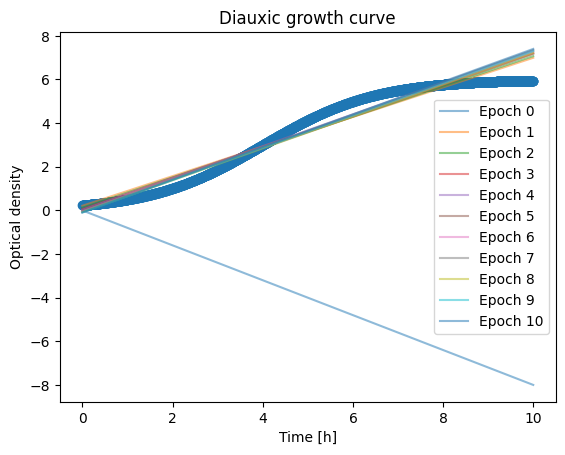

In [98]:
# Fit model and record every epoch
for i in range(1,11):
  history_1 = model.fit(x_train, y_train, epochs=1, batch_size=32)
  pred = model.predict(x_train)
  model_pred_df[i] = pd.DataFrame(pred)

# Plot model progress as lines into whole dataset to see initial model prediction
plt.scatter(x_train, y_train)
for i in range(0, len(model_pred_df.columns)):
  plt.plot(x_train, model_pred_df[i], label="Epoch " + str(i), alpha=0.5)
plt.legend()
plt.xlabel("Time [h]")
plt.ylabel("Optical density")
plt.title("Diauxic growth curve");

---

It seems that our current model is stuck and can only represent a straight line.
However, the diauxic growth function uses an exponential term, and therefore our ANN architecture is not suited to deal with such a problem.

---

![](https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Artificial%20neuron.png?raw=true)

To overcome this problem and enable our ANN to model non-linear systems, we need to use a **non-linear activation function**.
In general, an activation function takes the output of a neuron (= dot product of weight vector and input vector + bias neuron) and transforms the output.


One common non-linear activation function is the **hyperbolic tangent** tanh = $\frac{e^{x} - e^{-x}} {e{^x} + e^{-x}}$

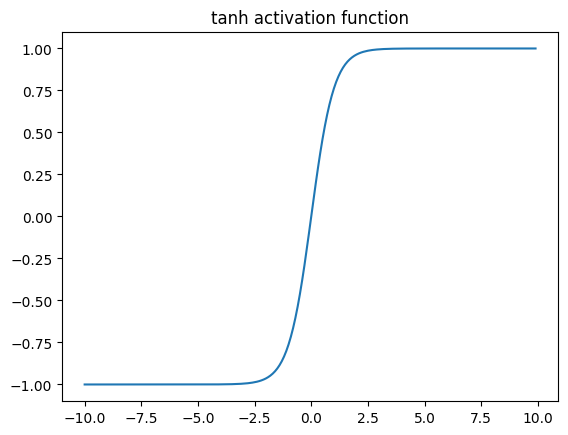

In [99]:
x_tanh = np.arange(-10,10, 0.1)
y_tanh = np.tanh(x_tanh)
plt.title("tanh activation function")
plt.plot(x_tanh, y_tanh);

## Model 2:

* **2 dense neurons** (input layer and output layer)
* Hyperbolic Tangent activation function for input layer **tanh(x)**
* **Linear activation function** for output layer
* Optimizer is **Stochastic Gradient Descent SGD**
* Loss function to minimize: **Mean Absolute Error MAE**
* Metrics to observe during training: **Mean Absolute Error MAE**
* Train the model for **100 epochs** and monitor every 10th epoch

![](https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Regression%20model%202.jpg?raw=true)

---

❓**Question**: Why do we now need 2 neurons now and cannot just use the hyperbolic tangent activation function for the 1 neuron we had in our previous model?

In [100]:
# Neural network for regression problem

# Build model
model = keras.Sequential([layers.Dense(units=1,
                                       input_shape=x_train.shape[1:],
                                       kernel_initializer=tf.initializers.Constant(-0.8),
                                       activation="tanh"),
                          layers.Dense(units=1)])

# Compile model
model.compile(optimizer="SGD",
              loss="MAE",
              metrics=["MAE"])

# Show summary of our model
model.summary()

# Record first prediction of x_train before training
pred_0 = model.predict(x_train)
model_pred_df = pd.DataFrame(pred_0)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
 dense_12 (Dense)            (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
63/63 [==============================] - 0s 1ms/step


Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 3.4491 - MAE: 3.4491
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 2.6888 - MAE: 2.6888
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 2.3068 - MAE: 2.3068
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 2.0594 - MAE: 2.0594
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 1.8344 - MAE: 1.8344
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 1.5311 - MAE: 1.5311
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 1.2192 - MAE: 1.2192
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.8777 - MAE: 0.8777
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.5917 - MAE: 0.5917
Epoch 10/10
63/63 [==============================] - 0s 1ms/step
Epoch 1/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2179 - MAE: 0.2179
Epoch

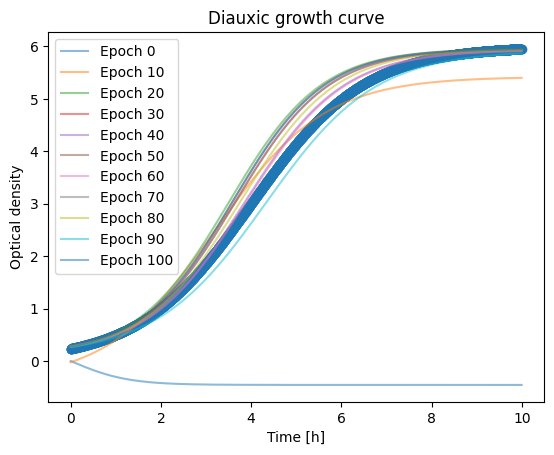

In [101]:
# Fit model and record every 10th epoch
for i in range(1,11):
  history_1 = model.fit(x_train, y_train, epochs=10, batch_size=32)
  pred = model.predict(x_train)
  model_pred_df[i] = pd.DataFrame(pred)

# Plot model progress as lines into whole dataset to see initial model prediction
plt.scatter(x_train, y_train)
for i in range(0, len(model_pred_df.columns)):
  plt.plot(x_train, model_pred_df[i], label="Epoch " + str(i*10), alpha=0.5)
plt.legend()
plt.xlabel("Time [h]")
plt.ylabel("Optical density")
plt.title("Diauxic growth curve");

# **Exercise:** Try to build a neural network, that can model a circadian pattern.

**First we create the data set with 1000 points**

 Datapoints in x_train: 1000 
 Shape of x_train: (1000, 1)

 Datapoints in y_train: 1000 
 Shape of y_train: (1000, 1)



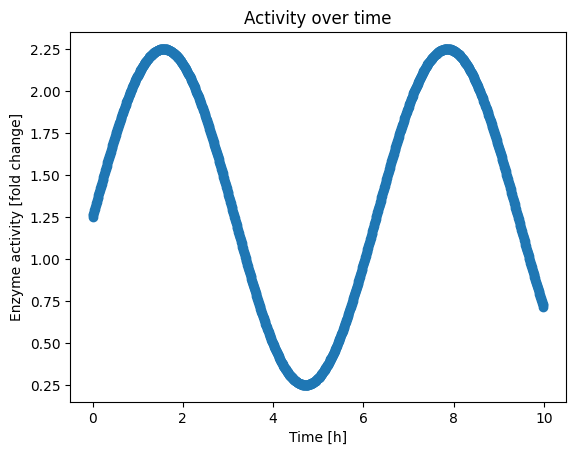

In [102]:
# Create dataset
x = np.arange(0,10,0.01)
y = np.sin(x) + 1.25

# Convert the list objects into tensors for downstream calculations
x_train = tf.convert_to_tensor(x)
y_train = tf.convert_to_tensor(y)

# Reshape tensors into format batch size - values
x_train = tf.expand_dims(x_train, axis=1)
y_train = tf.expand_dims(y_train, axis=1)

# Check if split was successful
print(f" Datapoints in x_train: {len(x_train)} \n Shape of x_train: {x_train.shape}\n")
print(f" Datapoints in y_train: {len(y_train)} \n Shape of y_train: {y_train.shape}\n")

# Visualize the dataset
plt.scatter(x_train, y_train)
plt.xlabel("Time [h]")
plt.ylabel("Enzyme activity [fold change]")
plt.title("Activity over time");

**To do:**

1. Fill in the hyperparameters and play around with them. Each experiment starts with the following cell
2. See how the model adapts to the data set.
3. Evaluate your best model by predicting the y-values for x_test and calculating the MAE for the differences.
4. Examine how network performance changes between small and large networks

Network architecture and adjustable hyperparameters:

|Layer name|Number of neurons|Activation function|
|----------|-----------------|-------------------|
|Layer 1|units_1|activation_1|
|Layer 2|units_2|activation_2|
|Layer 3|units_3|activation_3|
|Output layer|units_output|activation_output|

---

**epochs_per_cycle** = Number of training epochs per cycle. We always run 10 cycles (so e.g. epochs_per_cycle=10 results in a total of 100 epochs).

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                128       
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 1ms/step
Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 0.8018 - MAE: 0.8018
Epoch 2/10
32/32 [===================

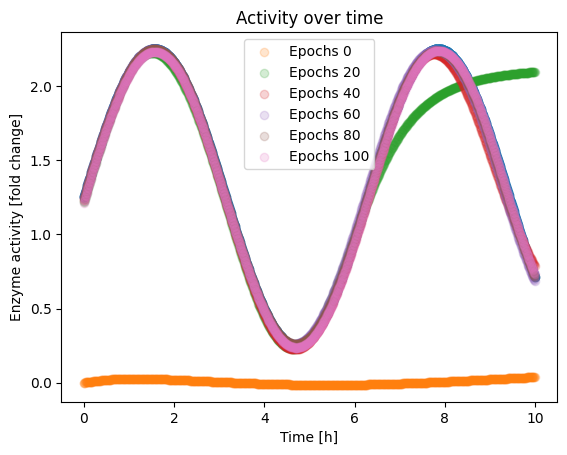

In [103]:
# Fill out the hyperparameters

# units_i is the number of neurons in layer i. Typical values are 0-100
units_1 = 64
units_2 = 32
units_3 = 16
units_output = 1
# activation_i is the activation function for layer i. You can use "linear", "tanh", "elu"
activation_1 ="tanh"
activation_2 ="tanh"
activation_3 ="tanh"
activation_output ="linear"
# epochs_per_cycle is the number of epochs trained per cycle.
#Remember we use 10 cycles so epochs=10 leads to 100 training epochs in total
epochs_per_cycle = 10

########### Do not change anything below!

# Build model
model = keras.Sequential([layers.Dense(units=units_1, activation=activation_1, input_shape=x_train.shape[1:]),
                          layers.Dense(units=units_2, activation=activation_2),
                          layers.Dense(units=units_3, activation=activation_3),
                          layers.Dense(units=units_output, activation=activation_output)])
# Compile model
model.compile(optimizer="adam",
              loss="MAE",
              metrics=["MAE"])

# Show summary of our model
model.summary()

# Record first prediction of x_train before training
pred_0 = model.predict(x_train)
model_pred_df = pd.DataFrame(pred_0)

# Fit model and record every cycle
for i in range(1,11):
  model.fit(x_train, y_train, epochs=epochs_per_cycle, batch_size=32)
  pred = model.predict(x_train)
  model_pred_df[i] = pd.DataFrame(pred)

# Plot model progress as lines into whole dataset to see initial model prediction
plt.scatter(x_train, y_train)
for i in range(0, len(model_pred_df.columns), 2):
  plt.scatter(x_train, model_pred_df[i], label="Epochs " + str(i*epochs_per_cycle), alpha=0.2)
plt.xlabel("Time [h]")
plt.legend()
plt.ylabel("Enzyme activity [fold change]")
plt.title("Activity over time");

**When you are happy with your model, evaluate it and write down the best MAE value**

In [104]:
# Evaluate MAE on whole dataset
evaluation = model.evaluate(x_train, y_train)[1]
print(f"Evaluation MAE:  {round(evaluation,3)}")

32/32 [==============================] - 0s 2ms/step - loss: 0.0160 - MAE: 0.0160
Evaluation MAE:  0.016


# The problem of data transferability and overfitting

We know that the pattern of the data is periodic and should repeat every ~6 hours.

Does our model know this?

**First, we extend the data set to cover the interval [-20,30] on the x-axis**.

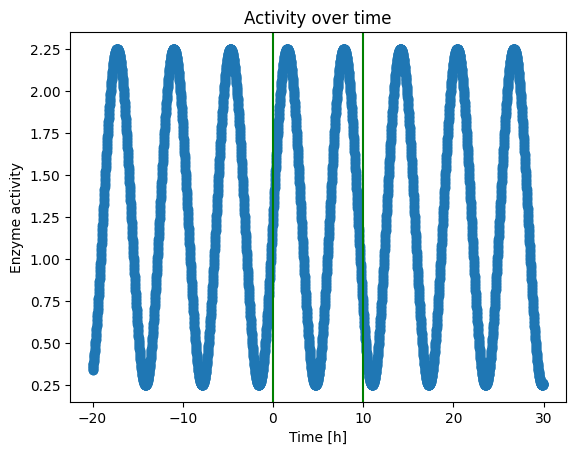

In [105]:
# Extent dataset
x_testing =  np.arange(-20,30,0.01)
x_testing = tf.convert_to_tensor(x_testing)
x_testing = tf.expand_dims(x_testing, axis=1)
y_testing_true = np.sin(x_testing) + 1.25

# Plot the extended dataset
plt.scatter(x_testing, y_testing_true, label="True");
plt.axvline(x=0, color="green")
plt.axvline(x=10, color="green")
plt.xlabel("Time [h]")
plt.ylabel("Enzyme activity")
plt.title("Activity over time");

**Now we will use our previously trained ANN to predict the enzyme activity values over the entire range of the extended dataset**

157/157 [==============================] - 0s 2ms/step


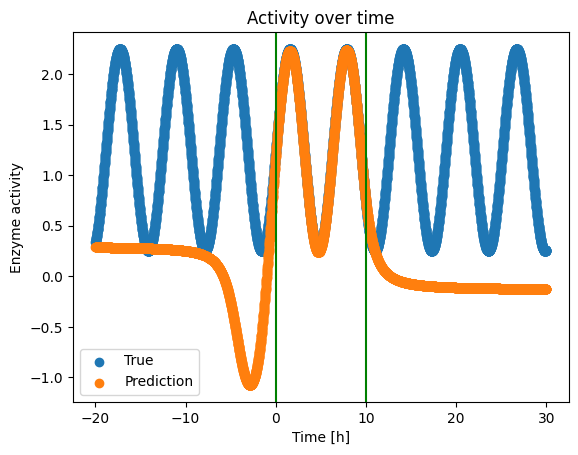

In [106]:
# Let model predict y values above the whole expanded dataset
y_testing = model.predict(x_testing)

# Plot models predictions and expanded dataset
plt.scatter(x_testing, y_testing_true, label="True")
plt.scatter(x_testing, y_testing, label="Prediction")
plt.legend()
plt.axvline(x=0, color="green")
plt.axvline(x=10, color="green")
plt.xlabel("Time [h]")
plt.ylabel("Enzyme activity")
plt.title("Activity over time");

Our model performs very well within the interval it was trained on (and a small adjacent part outside of that interval). However, its performance on the unseen data is very poor. In general, ANNs are often better at interpolation (predicting values within the range of the training data) than at extrapolation.

From this we can learn 2 basic concepts:
1. (Most) ANNs do not perform very well on unseen data, and therefore the data used to train an ANN must be **representative** of the underlying system.
2. (Most) ANNs will still give you an output, and evaluating the **quality of that output** is a topic in itself.

An important concept to avoid such a situation, where an ANN performs very well on training data, but its performance decreases when applied, is called **holdout validation**.

Here, the data set is divided into 3 subsets:
1. **Training data**
  - Used to train the model
2. **Validation data**
  - Used to validate model performance during training and development on unseen data
3. **Test data**
  - Used to validate the model's final performance after the development phase and to compare its performance with other models.


**Picture**

We will use this concept in **Chapter 2 - Classification**.